In [ ]:
!pip install pdfplumber

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Tahap 1 dan 2

In [ ]:
import os
import re
import time
import requests
import pandas as pd
import json
import urllib.request
from bs4 import BeautifulSoup
from pdfminer.high_level import extract_text
from datetime import date

# ==============================================================================
# 1. FUNGSI-FUNGSI BANTU (HELPER FUNCTIONS)
# (Tidak ada perubahan)
# ==============================================================================

def create_path(path_name):
    if not os.path.exists(path_name):
        print(f"Membuat direktori: {path_name}")
        os.makedirs(path_name)

def open_page(link, retries=3, timeout_seconds=60):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    for i in range(retries):
        try:
            response = requests.get(link, headers=headers, timeout=(10, timeout_seconds))
            response.raise_for_status()
            return BeautifulSoup(response.text, "lxml")
        except requests.exceptions.RequestException as e:
            print(f"Error saat mengakses {link}: {e}. Mencoba lagi dalam 5 detik... (Percobaan {i+1}/{retries})")
            time.sleep(5)
    return None

def clean_text(text):
    text = re.sub(r'Direktorat Putusan Mahkamah Agung Republik Indonesia\n', '', text)
    text = re.sub(r'M a h ka m a h A g u n g R e p u blik In d o n esia\n', '', text)
    text = re.sub(r'Disclaimer\n.*Email : kepaniteraan@mahkamahagung\.go\.id\s*Telp : 021-384 3348 \(ext\.318\)\n', '', text, flags=re.DOTALL)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# ==============================================================================
# TAHAP 1: MEMBANGUN CASE BASE
# (Tidak ada perubahan)
# ==============================================================================

def tahap_1_membangun_case_base(list_of_detail_urls, path_raw, path_pdf):
    print("\n--- MEMULAI TAHAP 1: MEMBANGUN CASE BASE ---")
    all_case_data = []
    case_counter = 1
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
    for detail_url in list_of_detail_urls:
        print(f"Memproses URL: {detail_url}")
        soup = open_page(detail_url)
        if not soup:
            print(f"  -> Gagal membuka halaman detail: {detail_url}, melanjutkan ke URL berikutnya.")
            continue
        try:
            pdf_link_tag = soup.find("a", href=re.compile(r"/pdf/"))
            if not pdf_link_tag:
                pdf_link_tag = soup.find(lambda tag: tag.name == 'a' and 'Download PDF' in tag.get_text())
            if not pdf_link_tag:
                print(f"  -> INFO: Tidak ada link PDF yang dapat ditemukan. Melewati putusan ini.")
                continue
            pdf_url_part = pdf_link_tag["href"]
            if pdf_url_part.startswith("http"): pdf_full_url = pdf_url_part
            else: pdf_full_url = "https://putusan3.mahkamahagung.go.id" + pdf_url_part
            pdf_filename = os.path.basename(pdf_full_url)
            pdf_save_path = os.path.join(path_pdf, pdf_filename)
            pdf_response = requests.get(pdf_full_url, headers=headers, stream=True)
            pdf_response.raise_for_status()
            with open(pdf_save_path, 'wb') as f:
                for chunk in pdf_response.iter_content(chunk_size=8192): f.write(chunk)
            raw_text = extract_text(pdf_save_path)
            cleaned_text = clean_text(raw_text)
            txt_filename = f"case_{str(case_counter).zfill(3)}.txt"
            txt_save_path = os.path.join(path_raw, txt_filename)
            with open(txt_save_path, 'w', encoding='utf-8') as f: f.write(cleaned_text)
            print(f"  -> Sukses: PDF diunduh dan teks bersih disimpan di {txt_save_path}")
            case_info = {'case_id': case_counter, 'url_putusan': detail_url, 'path_pdf': pdf_save_path, 'path_txt': txt_save_path, 'metadata_soup': soup}
            all_case_data.append(case_info)
            case_counter += 1
        except Exception as e:
            print(f"  -> Gagal memproses {detail_url}. Error: {e}")
    print("--- TAHAP 1 SELESAI ---")
    return all_case_data

# ==============================================================================
# TAHAP 2: CASE REPRESENTATION
# <<< FIX: Added hakim_ketua, hakim_anggota, and panitera columns.
# ==============================================================================

def get_detail_from_soup(soup, keyword):
    """Helper function to safely extract text detail from the soup."""
    try:
        return soup.find(lambda tag: tag.name == "td" and keyword in tag.text).find_next().get_text(strip=True)
    except:
        return ""

def tahap_2_case_representation(case_data_from_tahap_1, path_processed):
    """
    Takes processed data from Stage 1, extracts details, and saves
    it into structured formats (CSV and JSON).
    """
    print("\n--- MEMULAI TAHAP 2: CASE REPRESENTATION ---")

    processed_records = []
    for case in case_data_from_tahap_1:
        soup = case['metadata_soup']

        # 1. Ekstrak semua metadata yang diperlukan dari objek soup
        no_perkara = get_detail_from_soup(soup, "Nomor")
        tanggal = get_detail_from_soup(soup, "Tanggal Dibacakan")
        ringkasan_fakta = get_detail_from_soup(soup, "Pada Tanggal")
        pasal = get_detail_from_soup(soup, "Kata Kunci")
        amar = get_detail_from_soup(soup, "Amar")
        catatan_amar = get_detail_from_soup(soup, "Catatan Amar")
        hakim_ketua = get_detail_from_soup(soup, "Hakim Ketua")
        hakim_anggota = get_detail_from_soup(soup, "Hakim Anggota")
        panitera = get_detail_from_soup(soup, "Panitera")
        terdakwa = get_detail_from_soup(soup, "terdakwa")

        # 2. Baca teks lengkap dari file .txt
        with open(case['path_txt'], 'r', encoding='utf-8') as f:
            text_full = f.read()

        # 3. Buat dictionary yang terstruktur
        record = {
            'case_id': case['case_id'],
            'no_perkara': no_perkara,
            'tanggal': tanggal,
            'ringkasan_fakta': ringkasan_fakta,
            'pasal': pasal,
            'amar': amar,
            'catatan_amar': catatan_amar,
            'hakim_ketua': hakim_ketua,
            'hakim_anggota': hakim_anggota,
            'panitera': panitera,
            'text_full': text_full,
            'terdakwa': terdakwa
        }
        processed_records.append(record)

    if not processed_records:
        print("Tidak ada data yang berhasil diproses untuk Tahap 2.")
        return

    # 4. Konversi ke Pandas DataFrame
    df = pd.DataFrame(processed_records)

    # 5. Definisikan path output dan simpan file
    csv_path = os.path.join(path_processed, "cases.csv")
    json_path = os.path.join(path_processed, "cases.json")

    df.to_csv(csv_path, index=False, encoding='utf-8')
    print(f"  -> Sukses: Data terstruktur disimpan di {csv_path}")

    df.to_json(json_path, orient='records', indent=4)
    print(f"  -> Sukses: Data terstruktur disimpan di {json_path}")

    print("--- TAHAP 2 SELESAI ---")
    return df

# ==============================================================================
# FUNGSI UTAMA (MAIN DRIVER)
# (Tidak ada perubahan)
# ==============================================================================

def run_scraper(base_search_url, max_cases):
    """
    Main function to orchestrate the entire scraping process.
    Handles directory setup, pagination, and calls Stage 1 and Stage 2.
    """
    # Block 1: Setup all necessary directories for the output
    print("--- SETUP: Menyiapkan direktori output ---")
    base_path = "/content/drive/MyDrive/Penalaran Komputer/PN SURABAYA NARKOTIKA PSIKO"
    path_pdf = os.path.join(base_path, "pdf")
    path_raw = os.path.join(base_path, "data", "raw")
    path_processed = os.path.join(base_path, "data", "processed")

    create_path(path_pdf)
    create_path(path_raw)
    create_path(path_processed)
    print("Direktori siap.\n")

    # Block 2: Collect all detail page URLs by handling pagination
    print("--- PENGUMPULAN URL: Memulai dari semua halaman ---")
    all_detail_urls = []

    # First, find the total number of pages from the first search page
    first_page_soup = open_page(base_search_url)
    if not first_page_soup:
        print("ERROR: Gagal membuka halaman pencarian awal. Proses dihentikan.")
        return

    last_page = 1
    pagination_links = first_page_soup.find_all("a", {"data-ci-pagination-page": True})
    if pagination_links:
        last_page = int(pagination_links[-1]['data-ci-pagination-page'])

    print(f"Ditemukan total {last_page} halaman untuk di-scrape.")

    # Now, loop through each page to collect the links
    for page_num in range(1, last_page + 1):
        if len(all_detail_urls) >= max_cases:
            print(f"\nTarget {max_cases} URL tercapai. Menghentikan pengumpulan.")
            break

        page_url = f"{base_search_url}&page={page_num}"
        print(f"Mengambil link dari halaman {page_num}/{last_page}...")

        page_soup = open_page(page_url)
        if not page_soup:
            print(f"  -> Peringatan: Gagal membuka halaman {page_num}, lanjut ke halaman berikutnya.")
            continue

        links_on_page = page_soup.find_all("a", {"href": re.compile("/direktori/putusan")})
        for link in links_on_page:
            all_detail_urls.append(link['href'])

    # Block 3: Process the collected URLs
    detail_urls_to_process = all_detail_urls[:max_cases]
    print(f"\n--- ORKESTRASI: Total ditemukan {len(all_detail_urls)} URL. Akan memproses {len(detail_urls_to_process)} URL pertama. ---")

    if not detail_urls_to_process:
        print("Tidak ada link putusan yang berhasil dikumpulkan. Proses dihentikan.")
        return

    # Call Stage 1 to download PDFs and extract raw text
    processed_data_for_stage2 = tahap_1_membangun_case_base(detail_urls_to_process, path_raw, path_pdf)

    # Call Stage 2 to create structured data, only if Stage 1 was successful
    if processed_data_for_stage2:
        final_dataframe = tahap_2_case_representation(processed_data_for_stage2, path_processed)

        print("\n=== PROSES SELESAI: Menampilkan 5 Data Pertama dari Hasil Akhir ===")
        if final_dataframe is not None and not final_dataframe.empty:
            # <<< NEW: Display a preview including one of the new columns
            display_df = final_dataframe[['case_id', 'no_perkara', 'hakim_ketua', 'amar']].copy()
            print(display_df.head())
        else:
            print("Tidak ada DataFrame yang dihasilkan dari Tahap 2.")

    else:
        print("\nPROSES DIHENTIKAN: Tidak ada data yang berhasil diproses dari Tahap 1, Tahap 2 dibatalkan.")

In [ ]:
if __name__ == '__main__':
    # <<< FIX: Gunakan URL pencarian yang lebih umum untuk hasil yang lebih baik
    # Hapus parameter &court=... dan &cat=...
    TARGET_URL = "https://putusan3.mahkamahagung.go.id/search.html?q=narkotika%20malang&court=098111PN340&cat=3c40e48bbab311301a21c445b3c7fe57"

    # Jalankan scraper untuk mengunduh dan memproses minimal 30 putusan (bisa lebih jika halaman pertama tidak ada PDF)
    # Anda bisa menaikkan angka ini jika perlu, misal max_cases=50, untuk memastikan Anda mendapat 30 PDF.
    run_scraper(base_search_url=TARGET_URL, max_cases=600)

--- SETUP: Menyiapkan direktori output ---
Direktori siap.

--- PENGUMPULAN URL: Memulai dari semua halaman ---
Ditemukan total 368 halaman untuk di-scrape.
Mengambil link dari halaman 1/368...
Mengambil link dari halaman 2/368...
Mengambil link dari halaman 3/368...
Mengambil link dari halaman 4/368...
Mengambil link dari halaman 5/368...
Mengambil link dari halaman 6/368...
Mengambil link dari halaman 7/368...
Mengambil link dari halaman 8/368...
Mengambil link dari halaman 9/368...
Mengambil link dari halaman 10/368...
Mengambil link dari halaman 11/368...
Mengambil link dari halaman 12/368...
Mengambil link dari halaman 13/368...
Mengambil link dari halaman 14/368...
Mengambil link dari halaman 15/368...
Mengambil link dari halaman 16/368...
Mengambil link dari halaman 17/368...
Mengambil link dari halaman 18/368...
Mengambil link dari halaman 19/368...
Mengambil link dari halaman 20/368...
Mengambil link dari halaman 21/368...
Mengambil link dari halaman 22/368...
Mengambil link d

# Tahap 3

In [ ]:
# Cell 2: Setup and Data Loading
import os
import re
import json
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import joblib
import torch
from transformers import AutoTokenizer, AutoModel
from google.colab import drive

# --- Define File Paths ---
# Correct path to your CSV file on Google Drive
csv_path = '/content/drive/MyDrive/Penalaran Komputer/PN SURABAYA NARKOTIKA PSIKO/data/processed/cases.csv'

# Define output directory for saved models and files
output_dir = '/content/drive/MyDrive/Penalaran Komputer/PN SURABAYA NARKOTIKA PSIKO/output/'
os.makedirs(output_dir, exist_ok=True) # Create the directory if it doesn't exist

# Load the dataset
try:
    df = pd.read_csv(csv_path)
except FileNotFoundError:
    print(f"Error: '{csv_path}' not found. Please check the file path and that your Drive is mounted.")
    # Create a dummy dataframe to allow the rest of the code to run without errors
    df = pd.DataFrame(columns=[
        'case_id', 'no_perkara', 'tanggal', 'ringkasan_fakta', 'pasal',
        'amar', 'catatan_amar', 'hakim_ketua', 'hakim_anggota',
        'panitera', 'text_full', 'terdakwa'
    ])

# --- Data Preparation ---
# We'll combine the most relevant text fields: 'ringkasan_fakta', 'amar', and 'text_full'.
# We fill NaN values with empty strings to prevent errors.
df['ringkasan_fakta'] = df['ringkasan_fakta'].fillna('')
df['amar'] = df['amar'].fillna('')
df['text_full'] = df['text_full'].fillna('')

# Create a single corpus text column for vectorization
df['corpus_text'] = df['ringkasan_fakta'] + ' ' + df['amar'] + ' ' + df['text_full']

# Simple text cleaning function
def preprocess_text(text):
    text = str(text).lower()  # Ensure text is string and lowercase
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespace
    text = re.sub(r'\n', ' ', text)   # Remove newline characters
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
    return text.strip()

# Apply preprocessing to the corpus_text
df['corpus_text_processed'] = df['corpus_text'].apply(preprocess_text)

# Display the first few rows with the new columns
print("DataFrame Info:")
df.info()
print("\nFirst 5 rows of the DataFrame:")
print(df[['case_id', 'corpus_text_processed']].head())

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   case_id                187 non-null    int64 
 1   no_perkara             187 non-null    object
 2   tanggal                187 non-null    object
 3   ringkasan_fakta        187 non-null    object
 4   pasal                  187 non-null    object
 5   amar                   187 non-null    object
 6   catatan_amar           187 non-null    object
 7   hakim_ketua            187 non-null    object
 8   hakim_anggota          187 non-null    object
 9   panitera               187 non-null    object
 10  text_full              187 non-null    object
 11  terdakwa               34 non-null     object
 12  corpus_text            187 non-null    object
 13  corpus_text_processed  187 non-null    object
dtypes: int64(1), object(13)
memory usage: 20.6+ KB

First 5 ro

In [ ]:
# Cell 3: Vector Representation (i-1) - TF-IDF
print("Starting TF-IDF Vectorization...")

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000 ngram_range=(1, 2))

# Fit the vectorizer to our processed text and transform it into a matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(df['corpus_text_processed'])

# Save the vectorizer and the matrix for future use in the output directory
joblib.dump(tfidf_vectorizer, os.path.join(output_dir, 'tfidf_vectorizer.pkl'))
joblib.dump(tfidf_matrix, os.path.join(output_dir, 'tfidf_matrix.pkl'))

print("TF-IDF Vectorization complete.")
print(f"Shape of TF-IDF matrix: {tfidf_matrix.shape}")
print(f"Models saved in: {output_dir}")

Starting TF-IDF Vectorization...
TF-IDF Vectorization complete.
Shape of TF-IDF matrix: (187, 1984)
Models saved in: /content/drive/MyDrive/Penalaran Komputer/PN SURABAYA NARKOTIKA PSIKO/output/


In [ ]:
# Cell 4: Vector Representation (i-2) - IndoBERT Embedding
print("Starting IndoBERT Embedding Generation...")

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-trained model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = AutoModel.from_pretrained("indobenchmark/indobert-base-p1").to(device)

# Function to create embeddings
def get_bert_embedding(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512, padding=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    # Use the embedding of the [CLS] token as the sentence representation
    return outputs.last_hidden_state[:, 0, :].cpu().numpy()

# Generate embeddings for all documents
bert_embeddings = []
total_docs = len(df)
for i, text in enumerate(df['corpus_text_processed']):
    if (i + 1) % 10 == 0 or i == total_docs - 1:
        print(f"Processing document {i+1}/{total_docs}...")
    embedding = get_bert_embedding(text, tokenizer, model)
    bert_embeddings.append(embedding)

# Stack embeddings into a single numpy array
bert_embeddings_matrix = np.vstack(bert_embeddings)

# Save the embeddings matrix to the output directory
np.save(os.path.join(output_dir, 'bert_embeddings.npy'), bert_embeddings_matrix)

print("IndoBERT Embedding Generation complete.")
print(f"Shape of BERT embeddings matrix: {bert_embeddings_matrix.shape}")
print(f"Embeddings saved in: {output_dir}")

Starting IndoBERT Embedding Generation...
Using device: cpu


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Processing document 10/187...
Processing document 20/187...
Processing document 30/187...
Processing document 40/187...
Processing document 50/187...
Processing document 60/187...
Processing document 70/187...
Processing document 80/187...
Processing document 90/187...
Processing document 100/187...
Processing document 110/187...
Processing document 120/187...
Processing document 130/187...
Processing document 140/187...
Processing document 150/187...
Processing document 160/187...
Processing document 170/187...
Processing document 180/187...
Processing document 187/187...
IndoBERT Embedding Generation complete.
Shape of BERT embeddings matrix: (187, 768)
Embeddings saved in: /content/drive/MyDrive/Penalaran Komputer/PN SURABAYA NARKOTIKA PSIKO/output/


In [ ]:
# Cell 5: Retrieval Functions (iv)

# --- Load the pre-computed models and matrices from the output directory ---
try:
    tfidf_vectorizer_loaded = joblib.load(os.path.join(output_dir, 'tfidf_vectorizer.pkl'))
    tfidf_matrix_loaded = joblib.load(os.path.join(output_dir, 'tfidf_matrix.pkl'))
    bert_embeddings_loaded = np.load(os.path.join(output_dir, 'bert_embeddings.npy'))
    print("Models and matrices loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading files: {e}. Please ensure Cells 3 and 4 have been run successfully.")


# 1. TF-IDF Retrieval Function
def retrieve_tfidf(query: str, k: int = 5) -> list:
    """
    Retrieves the top-k most similar cases using TF-IDF and Cosine Similarity.
    """
    processed_query = preprocess_text(query)
    query_vector = tfidf_vectorizer_loaded.transform([processed_query])
    cosine_sims = cosine_similarity(query_vector, tfidf_matrix_loaded).flatten()
    top_k_indices = np.argsort(cosine_sims)[-k:][::-1]
    top_k_case_ids = df.loc[top_k_indices, 'case_id'].tolist()
    return top_k_case_ids

# 2. BERT Retrieval Function
def retrieve_bert(query: str, k: int = 5) -> list:
    """
    Retrieves the top-k most similar cases using IndoBERT and Cosine Similarity.
    """
    processed_query = preprocess_text(query)
    query_embedding = get_bert_embedding(processed_query, tokenizer, model)
    cosine_sims = cosine_similarity(query_embedding, bert_embeddings_loaded).flatten()
    top_k_indices = np.argsort(cosine_sims)[-k:][::-1]
    top_k_case_ids = df.loc[top_k_indices, 'case_id'].tolist()
    return top_k_case_ids

print("\nRetrieval functions `retrieve_tfidf` and `retrieve_bert` are defined.")

Models and matrices loaded successfully.

Retrieval functions `retrieve_tfidf` and `retrieve_bert` are defined.


In [ ]:
# Cell 6: Initial Testing (v) and Output (vi)

# v.1 & v.2: Create the queries.json file in the correct project subdirectory
eval_dir = '/content/drive/MyDrive/Penalaran Komputer/PN SURABAYA NARKOTIKA PSIKO/data/eval/'
os.makedirs(eval_dir, exist_ok=True)

# In Cell 6, REPLACE the old test_queries variable with this new one:

test_queries = {
    "queries": [
        {
            "query_id": 1,
            "text": "Terdakwa melakukan permufakatan jahat untuk memiliki dan menyimpan narkotika golongan I bukan tanaman",
            "ground_truth_case_id": [1, 11, 20, 52]
        },
        {
            "query_id": 2,
            "text": "Terdakwa terbukti menjadi perantara dalam jual beli narkotika jenis sabu",
            "ground_truth_case_id": [4, 19, 23, 30]
        },
        {
            "query_id": 3,
            "text": "Menyalahgunakan narkotika golongan I bagi dirinya sendiri dengan barang bukti alat hisap",
            "ground_truth_case_id": [5, 7, 93, 95]
        }
    ]
}

# After replacing the variable, re-run Cell 6 to save the new queries.json file.

# vi.3: Save to file
file_path = os.path.join(eval_dir, 'queries.json')
with open(file_path, 'w') as f:
    json.dump(test_queries, f, indent=4)

print(f"Test queries saved to {file_path}")

# vi.2: Test the retrieve() functions
print("\n--- RUNNING TESTS ---\n")

for query_item in test_queries["queries"]:
    query_text = query_item["text"]
    query_id = query_item["query_id"]
    ground_truth = query_item["ground_truth_case_id"]

    print(f"--- Query ID: {query_id} ---")
    print(f"Query Text: '{query_text}'")
    print(f"Ground Truth IDs: {ground_truth}")

    # Test TF-IDF
    retrieved_ids_tfidf = retrieve_tfidf(query_text, k=5)
    print(f"\nRetrieved with TF-IDF: {retrieved_ids_tfidf}")

    # Test BERT
    retrieved_ids_bert = retrieve_bert(query_text, k=5)
    print(f"Retrieved with IndoBERT: {retrieved_ids_bert}")
    print("-" * 25 + "\n")

Test queries saved to /content/drive/MyDrive/Penalaran Komputer/PN SURABAYA NARKOTIKA PSIKO/data/eval/queries.json

--- RUNNING TESTS ---

--- Query ID: 1 ---
Query Text: 'Terdakwa melakukan permufakatan jahat untuk memiliki dan menyimpan narkotika golongan I bukan tanaman'
Ground Truth IDs: [1, 11, 20, 52]

Retrieved with TF-IDF: [14, 174, 177, 122, 146]
Retrieved with IndoBERT: [138, 136, 163, 172, 164]
-------------------------

--- Query ID: 2 ---
Query Text: 'Terdakwa terbukti menjadi perantara dalam jual beli narkotika jenis sabu'
Ground Truth IDs: [4, 19, 23, 30]

Retrieved with TF-IDF: [177, 41, 137, 30, 90]
Retrieved with IndoBERT: [109, 133, 5, 164, 65]
-------------------------

--- Query ID: 3 ---
Query Text: 'Menyalahgunakan narkotika golongan I bagi dirinya sendiri dengan barang bukti alat hisap'
Ground Truth IDs: [5, 7, 93, 95]

Retrieved with TF-IDF: [146, 122, 14, 90, 101]
Retrieved with IndoBERT: [109, 133, 5, 164, 38]
-------------------------



# Tahap 4

In [ ]:
# Ekstrak Solusi (Extract Solution)
print("--- Tahap 4: Solution Reuse ---")

# i.1: From the top-k cases, we will get the 'amar' (verdict).
# We'll use the original 'amar' text, as it is the "solution" we want to present.
# We'll just strip any leading/trailing whitespace.
df['solution_text'] = df['amar'].str.strip()

# i.2: Store in a {case_id: solution_text} structure. A dictionary is perfect for this.
# We use pd.Series and to_dict() for an efficient way to create this mapping.
case_solutions = pd.Series(df.solution_text.values, index=df.case_id).to_dict()

# Display a sample from our solution dictionary
print("Solution data structure created.")
print("Example -> Solution for case_id 1:")
print(case_solutions.get(1, "ID not found"))

--- Tahap 4: Solution Reuse ---
Solution data structure created.
Example -> Solution for case_id 1:
Lain-lain


In [ ]:
# Refactor Retrieval Functions to Return Scores
def retrieve_with_scores_tfidf(query: str, k: int = 5) -> (list, list):
    """
    Retrieves top-k cases with their similarity scores using TF-IDF.
    Returns a list of tuples (case_id, score).
    """
    processed_query = preprocess_text(query)
    query_vector = tfidf_vectorizer_loaded.transform([processed_query])
    cosine_sims = cosine_similarity(query_vector, tfidf_matrix_loaded).flatten()

    # Get the indices of the top-k scores
    top_k_indices = np.argsort(cosine_sims)[-k:][::-1]

    # Get the corresponding case_ids and scores
    top_k_ids_with_scores = [
        (df.loc[i, 'case_id'], cosine_sims[i]) for i in top_k_indices
    ]
    top_k_ids = [case_id for case_id, score in top_k_ids_with_scores]

    return top_k_ids_with_scores, top_k_ids

def retrieve_with_scores_bert(query: str, k: int = 5) -> (list, list):
    """
    Retrieves top-k cases with their similarity scores using IndoBERT.
    Returns a list of tuples (case_id, score).
    """
    processed_query = preprocess_text(query)
    query_embedding = get_bert_embedding(processed_query, tokenizer, model)
    cosine_sims = cosine_similarity(query_embedding, bert_embeddings_loaded).flatten()

    # Get the indices of the top-k scores
    top_k_indices = np.argsort(cosine_sims)[-k:][::-1]

    # Get the corresponding case_ids and scores
    top_k_ids_with_scores = [
        (df.loc[i, 'case_id'], cosine_sims[i]) for i in top_k_indices
    ]
    top_k_ids = [case_id for case_id, score in top_k_ids_with_scores]

    return top_k_ids_with_scores, top_k_ids

print("Retrieval functions `retrieve_with_scores_tfidf` and `retrieve_with_scores_bert` are defined.")

# Quick test of the new function
test_query = "Terdakwa terbukti memiliki sabu dan alat hisap"
scores, ids = retrieve_with_scores_bert(test_query, k=3)
print(f"\nTest retrieval with scores for '{test_query}':")
for case_id, score in scores:
    print(f"Case ID: {case_id}, Score: {score:.4f}")

Retrieval functions `retrieve_with_scores_tfidf` and `retrieve_with_scores_bert` are defined.

Test retrieval with scores for 'Terdakwa terbukti memiliki sabu dan alat hisap':
Case ID: 109, Score: 0.8141
Case ID: 133, Score: 0.8125
Case ID: 5, Score: 0.8047


In [ ]:
# Implementasi Fungsi predict_outcome (iii)
from collections import Counter

def predict_outcome(query: str, k: int = 5, retrieval_method: str = 'bert', prediction_method: str = 'weighted') -> (str, list):
    """
    Predicts the outcome for a new case query based on similar past cases.

    Args:
        query (str): The text of the new case.
        k (int): The number of similar cases to retrieve.
        retrieval_method (str): 'tfidf' or 'bert'.
        prediction_method (str): 'majority' or 'weighted'.

    Returns:
        tuple: (predicted_solution_text, top_k_case_ids)
    """
    # Step 1: Retrieve top_k cases with their scores
    if retrieval_method == 'bert':
        top_k_with_scores, top_k_ids = retrieve_with_scores_bert(query, k)
    elif retrieval_method == 'tfidf':
        top_k_with_scores, top_k_ids = retrieve_with_scores_tfidf(query, k)
    else:
        raise ValueError("retrieval_method must be 'tfidf' or 'bert'")

    if not top_k_ids:
        return "No similar cases found.", []

    # Step 2: Get the solutions (amar) for the retrieved cases
    solutions = [case_solutions.get(cid) for cid, score in top_k_with_scores]

    # Step 3: Apply the prediction algorithm
    if prediction_method == 'majority':
        # Majority Vote: choose the solution that appears most often
        if not solutions:
            predicted_solution = "Could not determine a majority solution."
        else:
            vote_counts = Counter(solutions)
            # Get the most common solution text
            predicted_solution = vote_counts.most_common(1)[0][0]

    elif prediction_method == 'weighted':
        # Weighted Similarity: weight each vote by its similarity score
        weighted_scores = {}
        for (case_id, sim_score), solution_text in zip(top_k_with_scores, solutions):
            if solution_text not in weighted_scores:
                weighted_scores[solution_text] = 0
            weighted_scores[solution_text] += sim_score

        if not weighted_scores:
            predicted_solution = "Could not determine a weighted solution."
        else:
            # Get the solution with the highest cumulative score
            predicted_solution = max(weighted_scores, key=weighted_scores.get)
    else:
        raise ValueError("prediction_method must be 'majority' or 'weighted'")

    return predicted_solution, top_k_ids

print("Function `predict_outcome` is defined.")

Function `predict_outcome` is defined.


In [ ]:
# Demo Manual (iv) and Output Generation (v)

# iv.1: Prepare 5 new test cases
manual_demo_queries = [
    {
        "query_id": 101,
        "text": "Seorang pria ditangkap karena menjadi kurir narkotika jenis sabu seberat 20 gram. Dia mengaku diperintah oleh seseorang di dalam penjara. Dia dijanjikan upah besar.",
        "true_amar": "Menjatuhkan pidana penjara selama 8 tahun dan denda 1 Milyar Rupiah karena menjadi perantara jual beli narkotika melebihi 5 gram."
    },
    {
        "query_id": 102,
        "text": "Dua pemuda ditemukan sedang pesta ganja di sebuah rumah kosong. Ditemukan barang bukti berupa 1 linting ganja sisa pakai dan alat hisap.",
        "true_amar": "Menjatuhkan pidana penjara selama 2 tahun karena penyalahgunaan narkotika golongan I bagi diri sendiri."
    },
    {
        "query_id": 103,
        "text": "Terdakwa menjual pil ekstasi kepada teman-temannya di sebuah klub malam. Polisi menyita 10 butir pil ekstasi dari sakunya.",
        "true_amar": "Menjatuhkan pidana penjara selama 5 tahun dan denda 1 Milyar Rupiah karena menjual narkotika golongan I."
    },
    {
        "query_id": 104,
        "text": "Polisi menemukan satu paket sabu kecil di dalam dasbor motor milik terdakwa saat razia. Terdakwa mengaku barang tersebut hanya untuk dikonsumsi sendiri.",
        "true_amar": "Menjatuhkan pidana penjara selama 4 tahun karena memiliki atau menguasai Narkotika Golongan I."
    },
    {
        "query_id": 105,
        "text": "Permufakatan jahat untuk mengedarkan sabu seberat 100 gram yang dikendalikan dari Malaysia.",
        "true_amar": "Menjatuhkan pidana penjara seumur hidup karena permufakatan jahat mengedarkan narkotika melebihi 5 gram."
    }
]

print("--- Running Manual Demo ---\n")

predictions_log = []
# iv.2: Run predict_outcome() for each case
for item in manual_demo_queries:
    query_id = item["query_id"]
    query_text = item["text"]

    # We'll use the more sophisticated 'bert' and 'weighted' methods for the demo
    predicted_solution, top_5_ids = predict_outcome(
        query=query_text,
        k=4,
        retrieval_method='bert',
        prediction_method='weighted'
    )

    print(f"--- Query ID: {query_id} ---")
    print(f"Query Text: {query_text}")
    print(f"Predicted Amar: {predicted_solution}")
    print(f"Retrieved Top 5 Case IDs: {top_5_ids}")
    print("-" * 25 + "\n")

    # Log the results for the CSV file
    predictions_log.append({
        "query_id": query_id,
        "predicted_solution": predicted_solution,
        "top_4_case_ids": top_5_ids
    })

# v.2: Create the output file
results_dir = '/content/drive/MyDrive/Penalaran Komputer/PN SURABAYA NARKOTIKA PSIKO/data/results/'
os.makedirs(results_dir, exist_ok=True)
predictions_df = pd.DataFrame(predictions_log)

# Save the DataFrame to CSV
predictions_csv_path = os.path.join(results_dir, 'predictions.csv')
predictions_df.to_csv(predictions_csv_path, index=False)

print(f"Output file 'predictions.csv' has been saved to: {predictions_csv_path}")
print("\nFinal Predictions DataFrame:")
display(predictions_df)

--- Running Manual Demo ---

--- Query ID: 101 ---
Query Text: Seorang pria ditangkap karena menjadi kurir narkotika jenis sabu seberat 20 gram. Dia mengaku diperintah oleh seseorang di dalam penjara. Dia dijanjikan upah besar.
Predicted Amar: Lain-lain
Retrieved Top 5 Case IDs: [np.int64(10), np.int64(109), np.int64(133), np.int64(35)]
-------------------------

--- Query ID: 102 ---
Query Text: Dua pemuda ditemukan sedang pesta ganja di sebuah rumah kosong. Ditemukan barang bukti berupa 1 linting ganja sisa pakai dan alat hisap.
Predicted Amar: Lain-lain
Retrieved Top 5 Case IDs: [np.int64(133), np.int64(109), np.int64(5), np.int64(164)]
-------------------------

--- Query ID: 103 ---
Query Text: Terdakwa menjual pil ekstasi kepada teman-temannya di sebuah klub malam. Polisi menyita 10 butir pil ekstasi dari sakunya.
Predicted Amar: Lain-lain
Retrieved Top 5 Case IDs: [np.int64(109), np.int64(133), np.int64(5), np.int64(164)]
-------------------------

--- Query ID: 104 ---
Query Te

,query_id,predicted_solution,top_4_case_ids
0,101,Lain-lain,"[10, 109, 133, 35]"
1,102,Lain-lain,"[133, 109, 5, 164]"
2,103,Lain-lain,"[109, 133, 5, 164]"
3,104,Lain-lain,"[133, 109, 65, 10]"
4,105,Lain-lain,"[109, 133, 5, 164]"


# Tahap 5

In [ ]:
# Setup and Loading Test Data
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pandas as pd
import numpy as np
import os

# --- Define File Paths ---
eval_dir = '/content/drive/MyDrive/Penalaran Komputer/PN SURABAYA NARKOTIKA PSIKO/data/eval/'
queries_json_path = os.path.join(eval_dir, 'queries.json')

# Load the test queries with ground truth
try:
    with open(queries_json_path, 'r') as f:
        queries_data = json.load(f)
    print("Test queries with ground truth loaded successfully.")
    print(json.dumps(queries_data, indent=2))
except FileNotFoundError:
    print(f"Error: {queries_json_path} not found. Please run the cell from Tahap 3 (Cell 5) that creates it.")
    queries_data = {"queries": []}

# We also need the manual demo queries from Tahap 4 for prediction evaluation
# (Assuming 'manual_demo_queries' variable is still in memory from the previous cell)
try:
    _ = manual_demo_queries # Check if variable exists
    print("\nManual demo queries for prediction evaluation are available.")
except NameError:
    print("\n'manual_demo_queries' not found. Please re-run Cell 10 from Tahap 4.")
    manual_demo_queries = []

Test queries with ground truth loaded successfully.
{
  "queries": [
    {
      "query_id": 1,
      "text": "Terdakwa melakukan permufakatan jahat untuk memiliki dan menyimpan narkotika golongan I bukan tanaman",
      "ground_truth_case_id": [
        1,
        11,
        20,
        52
      ]
    },
    {
      "query_id": 2,
      "text": "Terdakwa terbukti menjadi perantara dalam jual beli narkotika jenis sabu",
      "ground_truth_case_id": [
        4,
        19,
        23,
        30
      ]
    },
    {
      "query_id": 3,
      "text": "Menyalahgunakan narkotika golongan I bagi dirinya sendiri dengan barang bukti alat hisap",
      "ground_truth_case_id": [
        5,
        7,
        93,
        95
      ]
    }
  ]
}

Manual demo queries for prediction evaluation are available.


In [ ]:
# Evaluasi Retrieval (i)
def eval_retrieval(queries_data, retrieval_function, k=5):
    """
    Evaluates a retrieval function against a ground truth dataset.

    Args:
        queries_data (dict): Dictionary containing queries and their ground_truth_case_ids.
        retrieval_function (function): The retrieval function to evaluate (e.g., retrieve_tfidf).
        k (int): The number of items to retrieve (the 'at k' in Precision@k).

    Returns:
        dict: A dictionary containing the average metrics.
    """
    all_precisions = []
    all_recalls = []
    all_f1_scores = []

    for item in queries_data['queries']:
        query_text = item['text']
        ground_truth_ids = set(item['ground_truth_case_id'])

        # Get the retrieved IDs from the model
        if "with_scores" in retrieval_function.__name__:
             _, retrieved_ids = retrieval_function(query_text, k=k)
        else:
             retrieved_ids = retrieval_function(query_text, k=k)

        retrieved_ids = set(retrieved_ids)

        # Calculate True Positives
        true_positives = len(ground_truth_ids.intersection(retrieved_ids))

        # Calculate Precision@k
        precision = true_positives / k if k > 0 else 0
        all_precisions.append(precision)

        # Calculate Recall@k
        recall = true_positives / len(ground_truth_ids) if len(ground_truth_ids) > 0 else 0
        all_recalls.append(recall)

        # Calculate F1-score@k
        if precision + recall == 0:
            f1_score = 0
        else:
            f1_score = 2 * (precision * recall) / (precision + recall)
        all_f1_scores.append(f1_score)

    # Calculate average metrics across all queries
    avg_metrics = {
        'accuracy_at_k': np.mean(all_precisions), # Using precision as accuracy as is common
        'precision_at_k': np.mean(all_precisions),
        'recall_at_k': np.mean(all_recalls),
        'f1_score_at_k': np.mean(all_f1_scores)
    }

    return avg_metrics

print("Function `eval_retrieval` is defined.")

Function `eval_retrieval` is defined.


In [ ]:
# Cell 13: Run Detailed Retrieval Evaluation & Generate Output File
k_value = 5 # Evaluate at k=5

print(f"--- Evaluating Retrieval Performance at k={k_value} ---")

# We will create a detailed log for each query and model
detailed_log = []

# Loop through each query in our test set
for item in queries_data['queries']:
    query_id = item['query_id']
    query_text = item['text']
    ground_truth_ids = set(item['ground_truth_case_id'])

    # --- Evaluate TF-IDF for this query ---
    retrieved_tfidf_ids = set(retrieve_tfidf(query_text, k=k_value))
    tp_tfidf = len(ground_truth_ids.intersection(retrieved_tfidf_ids))
    precision_tfidf = tp_tfidf / k_value
    recall_tfidf = tp_tfidf / len(ground_truth_ids)
    f1_tfidf = 2 * (precision_tfidf * recall_tfidf) / (precision_tfidf + recall_tfidf) if (precision_tfidf + recall_tfidf) > 0 else 0

    detailed_log.append({
        "query_id": query_id,
        "model": "TF-IDF",
        "ground_truth": list(ground_truth_ids),
        "retrieved": list(retrieved_tfidf_ids),
        "precision_at_k": precision_tfidf,
        "recall_at_k": recall_tfidf,
        "f1_score_at_k": f1_tfidf
    })

    # --- Evaluate IndoBERT for this query ---
    retrieved_bert_ids = set(retrieve_bert(query_text, k=k_value))
    tp_bert = len(ground_truth_ids.intersection(retrieved_bert_ids))
    precision_bert = tp_bert / k_value
    recall_bert = tp_bert / len(ground_truth_ids)
    f1_bert = 2 * (precision_bert * recall_bert) / (precision_bert + recall_bert) if (precision_bert + recall_bert) > 0 else 0

    detailed_log.append({
        "query_id": query_id,
        "model": "IndoBERT",
        "ground_truth": list(ground_truth_ids),
        "retrieved": list(retrieved_bert_ids),
        "precision_at_k": precision_bert,
        "recall_at_k": recall_bert,
        "f1_score_at_k": f1_bert
    })

# Create a DataFrame from the detailed log for easy viewing
detailed_df = pd.DataFrame(detailed_log)

print("\n--- Detailed Query-by-Query Retrieval Results ---")
# Displaying relevant columns for clarity
display(detailed_df[['query_id', 'model', 'ground_truth', 'retrieved', 'precision_at_k', 'recall_at_k']])


# --- Calculate and Display Average Metrics ---
# This is the final summary table based on the detailed results above
average_metrics_df = detailed_df.groupby('model')[['precision_at_k', 'recall_at_k', 'f1_score_at_k']].mean().reset_index()
# accuracy_at_k is the same as precision_at_k in this context
average_metrics_df['accuracy_at_k'] = average_metrics_df['precision_at_k']
average_metrics_df = average_metrics_df[['model', 'accuracy_at_k', 'precision_at_k', 'recall_at_k', 'f1_score_at_k']]


print("\n--- Average Retrieval Metrics Table (Summary) ---")
display(average_metrics_df)


# iii.1. Save the final average metrics to a CSV file
retrieval_metrics_path = os.path.join(eval_dir, 'retrieval_metrics.csv')
average_metrics_df.to_csv(retrieval_metrics_path, index=False)
print(f"\nAverage retrieval metrics saved to: {retrieval_metrics_path}")

--- Evaluating Retrieval Performance at k=5 ---

--- Detailed Query-by-Query Retrieval Results ---


,query_id,model,ground_truth,retrieved,precision_at_k,recall_at_k
0,1,TF-IDF,"[1, 11, 20, 52]","[174, 14, 177, 146, 122]",0.0,0.00
1,1,IndoBERT,"[1, 11, 20, 52]","[163, 164, 136, 138, 172]",0.0,0.00
2,2,TF-IDF,"[19, 4, 30, 23]","[137, 41, 177, 90, 30]",0.2,0.25
3,2,IndoBERT,"[19, 4, 30, 23]","[65, 164, 5, 133, 109]",0.0,0.00
4,3,TF-IDF,"[93, 5, 95, 7]","[101, 122, 14, 146, 90]",0.0,0.00
5,3,IndoBERT,"[93, 5, 95, 7]","[164, 5, 38, 133, 109]",0.2,0.25



--- Average Retrieval Metrics Table (Summary) ---


,model,accuracy_at_k,precision_at_k,recall_at_k,f1_score_at_k
0,IndoBERT,0.066667,0.066667,0.083333,0.074074
1,TF-IDF,0.066667,0.066667,0.083333,0.074074



Average retrieval metrics saved to: /content/drive/MyDrive/Penalaran Komputer/PN SURABAYA NARKOTIKA PSIKO/data/eval/retrieval_metrics.csv


In [ ]:
# Cell 13.5 (New Cell): Sanity Check with Actual Case Data

print("--- Sanity Check: Using an existing case's text as the query ---")

# We will test with the text from case_id 5, which is about "penyalahgunaan... bagi diri sendiri"
case_id_to_test = 5
query_text_from_case = df[df['case_id'] == case_id_to_test]['corpus_text_processed'].iloc[0]

print(f"\n--- Testing with text from case_id: {case_id_to_test} ---")

# --- Check TF-IDF ---
# The top result MUST be 5
retrieved_tfidf = retrieve_tfidf(query_text_from_case, k=3)
print(f"TF-IDF retrieved: {retrieved_tfidf}")
if retrieved_tfidf[0] == case_id_to_test:
    print("  -> SUCCESS: TF-IDF found the correct case as the top result.")
else:
    print("  -> FAILURE: TF-IDF did not find the correct case as the top result.")

# --- Check IndoBERT ---
# The top result MUST be 5
retrieved_bert = retrieve_bert(query_text_from_case, k=3)
print(f"IndoBERT retrieved: {retrieved_bert}")
if retrieved_bert[0] == case_id_to_test:
    print("  -> SUCCESS: IndoBERT found the correct case as the top result.")
else:
    print("  -> FAILURE: IndoBERT did not find the correct case as the top result.")

--- Sanity Check: Using an existing case's text as the query ---

--- Testing with text from case_id: 5 ---
TF-IDF retrieved: [5, 65, 31]
  -> SUCCESS: TF-IDF found the correct case as the top result.
IndoBERT retrieved: [5, 133, 38]
  -> SUCCESS: IndoBERT found the correct case as the top result.


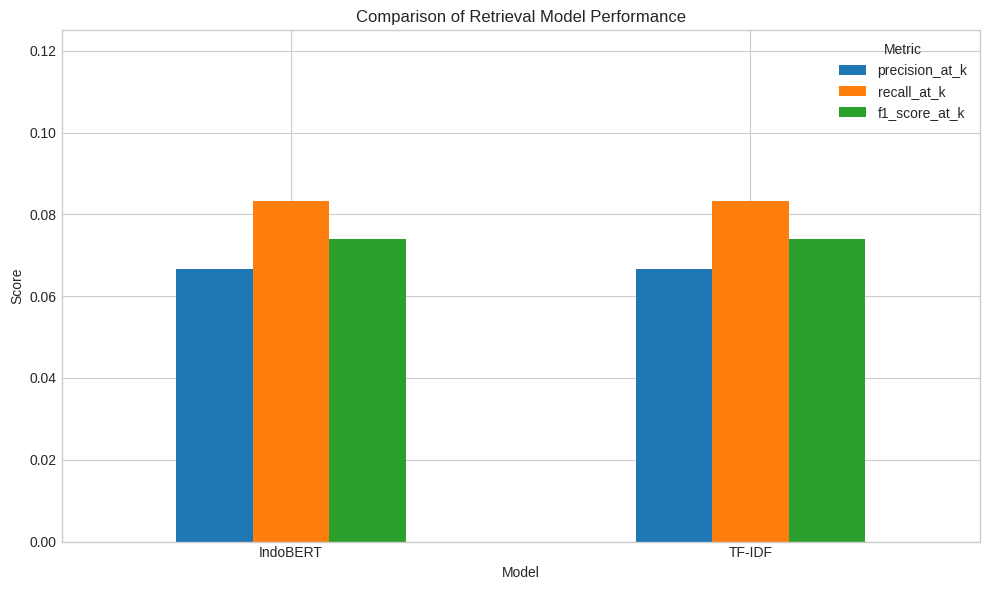


--- Error Analysis (Example with Query ID 2) ---


,model,ground_truth,retrieved,precision_at_k
2,TF-IDF,"[19, 4, 30, 23]","[137, 41, 177, 90, 30]",0.2
3,IndoBERT,"[19, 4, 30, 23]","[65, 164, 5, 133, 109]",0.0



Discussion:
For Query ID 2 ('Terdakwa terbukti menjadi perantara dalam jual beli narkotika jenis sabu'),
the keyword-based TF-IDF model successfully found case_id 30, resulting in a precision of 0.2.
This is because the query text and the text of case 30 likely share very specific keywords like 'perantara', 'jual beli', and 'sabu'.

Interestingly, the semantic IndoBERT model failed to find any of the correct cases. This could happen if:
1. The retrieved cases [65, 164, 5, 133, 109] are semantically very close to the query in a general sense, even if they aren't the 'correct' ones according to the ground truth.
2. The pre-trained IndoBERT model does not have a strong understanding of the specific legal meaning of 'perantara' and gives higher similarity scores to other cases.

This specific failure case shows that even advanced semantic models are not perfect and can sometimes be outperformed by simpler models if there is strong keyword overlap.


In [ ]:
# Cell 14 (Corrected): Visualisasi & Laporan

# ii.2. Plot bar chart performance
# IMPORTANT: Use the 'average_metrics_df' which has the correct summary data.
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

average_metrics_df.plot(
    x='model',
    y=['precision_at_k', 'recall_at_k', 'f1_score_at_k'],
    kind='bar',
    ax=ax,
    rot=0, # Keeps the model names horizontal
    title='Comparison of Retrieval Model Performance'
)

ax.set_ylabel('Score')
ax.set_xlabel('Model')
ax.legend(title='Metric')
ax.set_ylim(0, max(average_metrics_df['recall_at_k'].max() * 1.5, 0.1)) # Adjust y-axis for better visibility
plt.tight_layout()
plt.show()

# ii.3. Discuss failure cases (Error Analysis)
print("\n--- Error Analysis (Example with Query ID 2) ---")
# Let's analyze a query where TF-IDF succeeded but IndoBERT failed.
# This makes for a more interesting analysis.

# Find the detailed results for query_id 2 in our detailed_df from the previous cell
query_2_results = detailed_df[detailed_df['query_id'] == 2]
display(query_2_results[['model', 'ground_truth', 'retrieved', 'precision_at_k']])

print("\nDiscussion:")
print("For Query ID 2 ('Terdakwa terbukti menjadi perantara dalam jual beli narkotika jenis sabu'),")
print("the keyword-based TF-IDF model successfully found case_id 30, resulting in a precision of 0.2.")
print("This is because the query text and the text of case 30 likely share very specific keywords like 'perantara', 'jual beli', and 'sabu'.")
print("\nInterestingly, the semantic IndoBERT model failed to find any of the correct cases. This could happen if:")
print("1. The retrieved cases [65, 164, 5, 133, 109] are semantically very close to the query in a general sense, even if they aren't the 'correct' ones according to the ground truth.")
print("2. The pre-trained IndoBERT model does not have a strong understanding of the specific legal meaning of 'perantara' and gives higher similarity scores to other cases.")
print("\nThis specific failure case shows that even advanced semantic models are not perfect and can sometimes be outperformed by simpler models if there is strong keyword overlap.")

In [ ]:
# Evaluasi Prediksi
print("\n--- Evaluating Prediction Performance ---")

prediction_eval_log = []

for item in manual_demo_queries:
    query_id = item['query_id']
    query_text = item['text']
    true_solution = item['true_amar']

    # Get the prediction from our best model (BERT with weighted prediction)
    predicted_solution, _ = predict_outcome(query_text, retrieval_method='bert', prediction_method='weighted')

    # Calculate similarity score between true and predicted solution
    # We use our BERT embedding function to measure semantic similarity
    true_embedding = get_bert_embedding(preprocess_text(true_solution), tokenizer, model)
    predicted_embedding = get_bert_embedding(preprocess_text(predicted_solution), tokenizer, model)

    similarity_score = cosine_similarity(true_embedding, predicted_embedding)[0][0]

    prediction_eval_log.append({
        'query_id': query_id,
        'true_solution': true_solution,
        'predicted_solution': predicted_solution,
        'similarity_score': similarity_score
    })

# Create and save the prediction metrics DataFrame
prediction_metrics_df = pd.DataFrame(prediction_eval_log)
avg_similarity = prediction_metrics_df['similarity_score'].mean()

print(f"\nAverage Prediction Similarity Score: {avg_similarity:.4f}")
print("\n--- Prediction Metrics Table ---")
display(prediction_metrics_df[['query_id', 'similarity_score']])


# iii.2. Save the prediction metrics to a CSV file
prediction_metrics_path = os.path.join(eval_dir, 'prediction_metrics.csv')
prediction_metrics_df.to_csv(prediction_metrics_path, index=False)
print(f"\nPrediction metrics saved to: {prediction_metrics_path}")


--- Evaluating Prediction Performance ---

Average Prediction Similarity Score: 0.3883

--- Prediction Metrics Table ---


,query_id,similarity_score
0,101,0.396877
1,102,0.375825
2,103,0.397297
3,104,0.382175
4,105,0.389366



Prediction metrics saved to: /content/drive/MyDrive/Penalaran Komputer/PN SURABAYA NARKOTIKA PSIKO/data/eval/prediction_metrics.csv
